In [21]:
import math
import seaborn as sns
import array
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

**Signal - Noise - Filter Parameters**

In [ ]:
signal_length = 10000
period = 100

noise_level = 0.7

# Cutoff frequency as a fraction of the sampling rate.
fL = 0.01

# Filter length, must be odd.
N = period + 1

**Helping Functions for Heatmap Eye Diagram**

In [22]:
def bres_segment_count(x0, y0, x1, y1, grid):
    """Bresenham's algorithm.

    The value of grid[x,y] is incremented for each x,y
    in the line from (x0,y0) up to but not including (x1, y1).
    """

    if np.any(np.isnan([x0,y0,x1,y1])):
        return    

    nrows, ncols = grid.shape

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    sx = 0
    if x0 < x1:
        sx = 1
    else:
        sx = -1
    
    sy = 0
    if y0 < y1:
        sy = 1
    else:
        sy = -1

    err = dx - dy

    while True:
        # Note: this test is moved before setting
        # the value, so we don't set the last point.
        if x0 == x1 and y0 == y1:
            break

        if 0 <= x0 < nrows and 0 <= y0 < ncols:
            grid[int(x0), int(y0)] += 1

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def bres_curve_count(y, x, grid):
    for k in range(x.size - 1):
        x0 = x[k]
        y0 = y[k]
        x1 = x[k+1]
        y1 = y[k+1]
        bres_segment_count(x0, y0, x1, y1, grid)

def linear_scale(x,src_min,src_max,dst_min,dst_max):
    return dst_min+(x-src_min)*(dst_max-dst_min)/(src_max-src_min)

**Random Signal Generation**

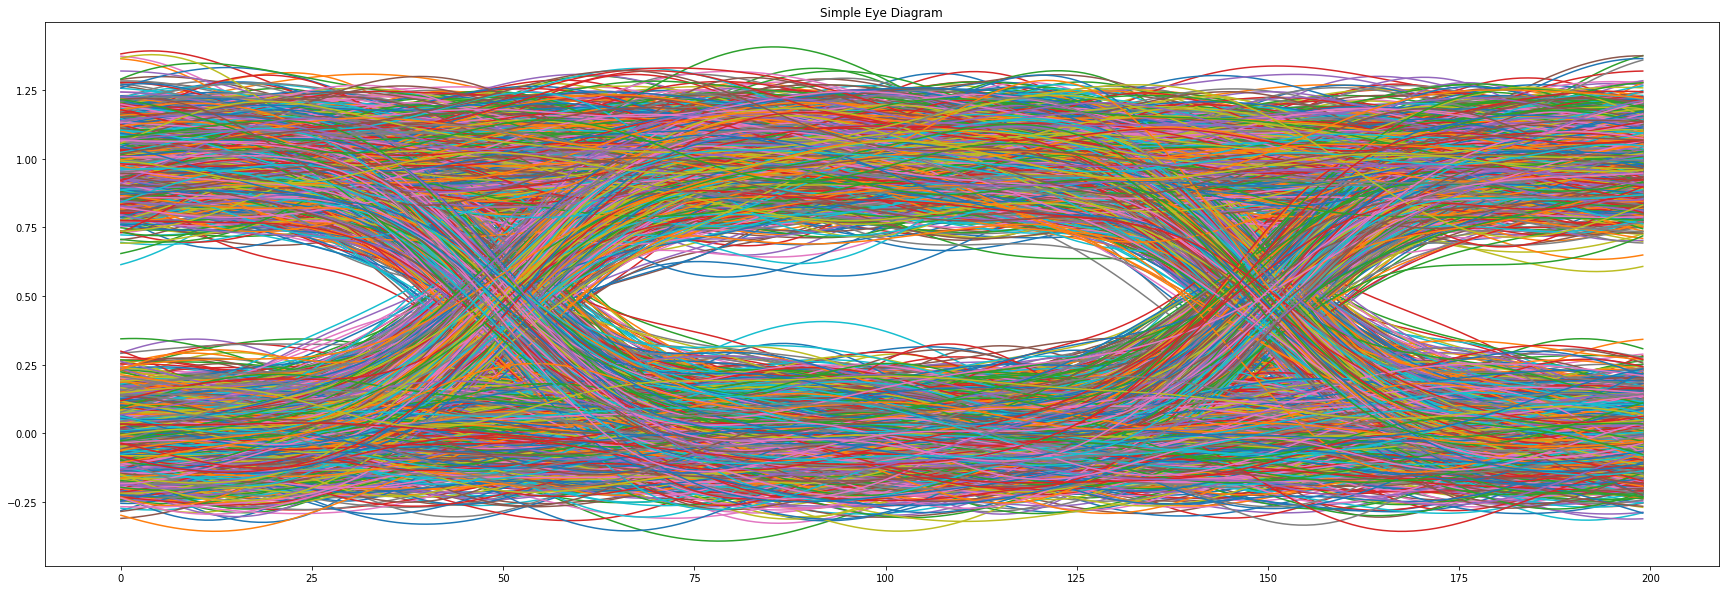

In [23]:
# Create random signal.
signal = np.random.randint(0, 2, signal_length)
signal_up = np.repeat(signal, period)

# Add noise.
signal_noise = signal_up + np.random.normal(0, noise_level, signal_length * period)

# Compute sinc filter.
h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2))

# Apply window.
h *= np.blackman(N)

# Normalize to get unity gain.
h /= np.sum(h)

signal_filtered = np.convolve(signal_noise, h)

if signal_length <= 1000:
    plt.figure(figsize=(30,10))
    plt.title('Signal')
    plt.plot(signal)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Signal + Noise')
    plt.plot(signal_noise)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Filtered Signal')
    plt.plot(signal_filtered)
    plt.show()

plt.figure(figsize=(30,10))
signal_noise = np.roll(signal_noise, period // 2)
for i in range (0, signal_length):
    sample = signal_filtered[int(i  * (period * 2)) : int((i+1) * (period * 2))]
    plt.plot(sample)
plt.title('Simple Eye Diagram')
plt.show()

**Heatmap Eye Diagram**

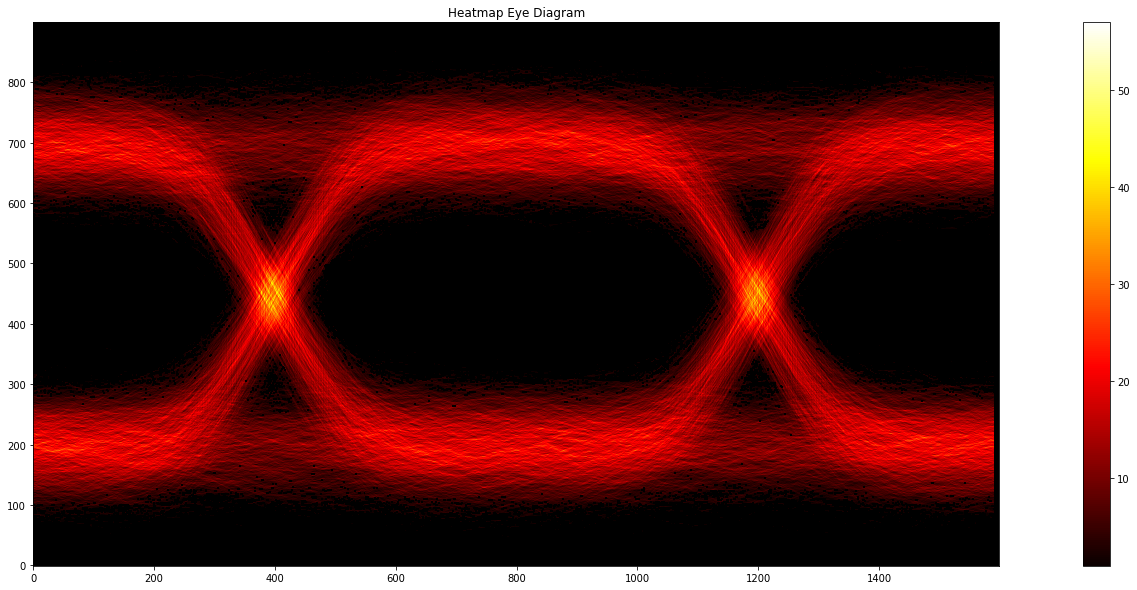

In [24]:
grid_W = 1600
grid_H = 900
grid = np.zeros((grid_H, grid_W), dtype=np.int32)

ys = []
for i in range(0, signal_length // 2):
    ys.append(signal_filtered[int(i * (period * 2) ) : int((i+1) * (period * 2))])

t_d = np.round(np.linspace(0, grid_W, period * 2 + 1, dtype=np.int32))

ymin = np.nanmin(ys)
ymax = np.nanmax(ys)
ys_d = []
for y in ys:
    ys_d.append(np.round(linear_scale(y,ymin,ymax,0,grid_H)))

for y_d in ys_d:
    bres_curve_count(t_d, y_d, grid)

plt.figure(figsize=(30,10))
grid = grid.astype(np.float32)
grid[grid==0] = np.nan
plt.imshow(grid, origin='lower', cmap=plt.cm.hot)
ax = plt.gca()
ax.set_facecolor('k')
plt.colorbar()
#plt.savefig("hand_made_persistence.png", bbox_inches='tight', dpi=300)
plt.title('Heatmap Eye Diagram')
plt.show()